### 1. Problem statement
 - We are given United Airline stock price from 01/2012 to 12/2017. 
 - The task is to predict the trend of the stock price for 01-06 2018. 

 - Test set -> UA stock from 2019-01-01 to 2020-12-31

### 2. Import library

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import Sequential
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt

### 3. Data processing

#### 3.0 import the data

In [2]:
stock = pd.read_csv('UAL.csv')

In [3]:
print(stock["Close"])
macd = MACD(close=stock["Close"])
stock["macd"] = macd.macd()
print(stock["macd"])

0      84.180000
1      80.000000
2      82.680000
3      83.230003
4      82.379997
         ...    
751    44.869999
752    44.580002
753    45.270000
754    44.430000
755    44.130001
Name: Close, Length: 756, dtype: float64
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
751   -0.814988
752   -0.633418
753   -0.428901
754   -0.330788
755   -0.274080
Name: macd, Length: 756, dtype: float64


In [4]:
# stock = pd.read_csv('Data/' + filename + '.csv')
indicator_bb = BollingerBands(close=stock["Close"], window=20, window_dev=2)
macd = MACD(close=stock["Close"])
rsi = RSIIndicator(close=stock["Close"])
ichi = IchimokuIndicator(high=stock["High"],low=stock["Low"])
stock['macd'] = macd.macd()
stock['rsi'] = rsi.rsi()
stock['bb_bbm'] = indicator_bb.bollinger_mavg()
stock['bb_bbh'] = indicator_bb.bollinger_hband()
stock['bb_bbl'] = indicator_bb.bollinger_lband()
stock['ichi_a'] = ichi.ichimoku_a()
stock['ichi_b'] = ichi.ichimoku_b()
stock['ichi_base'] = ichi.ichimoku_base_line()
stock['ichi_conv'] = ichi.ichimoku_conversion_line()
stock = stock.fillna(0)

print(stock['Close'][0])
print(stock.head(10))

84.18000030517578
         Date       Open       High        Low      Close  Adj Close   Volume  \
0  2019-01-02  81.690002  84.290001  81.410004  84.180000  84.180000  2973400   
1  2019-01-03  83.260002  83.260002  78.379997  80.000000  80.000000  6426200   
2  2019-01-04  80.879997  83.949997  80.769997  82.680000  82.680000  3808300   
3  2019-01-07  82.570000  83.919998  81.449997  83.230003  83.230003  2653000   
4  2019-01-08  83.300003  84.620003  81.889999  82.379997  82.379997  3910000   
5  2019-01-09  81.230003  83.919998  81.230003  83.760002  83.760002  5332600   
6  2019-01-10  80.730003  81.790001  77.389999  81.370003  81.370003  7376200   
7  2019-01-11  80.680000  80.970001  79.230003  80.070000  80.070000  4325300   
8  2019-01-14  79.279999  80.389999  78.680000  79.910004  79.910004  3951200   
9  2019-01-15  80.589996  82.099998  80.000000  81.199997  81.199997  5971900   

   macd  rsi  bb_bbm  bb_bbh  bb_bbl  ichi_a     ichi_b  ichi_base  ichi_conv  
0   0.0  0

### 3.1 Scaling

In [5]:
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock.iloc[:,1:4])
stock.iloc[:,1:4] = scaled_values

y_scaler = preprocessing.MinMaxScaler()
scaled_values = y_scaler.fit_transform(np.array(stock.iloc[:,4]).reshape(-1,1))
stock.iloc[:,4] = scaled_values

scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock.iloc[:,5:])
stock.iloc[:,5:] = scaled_values

### 3.2 Re-process data

Feature: 0, Score: -0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 1.00000
Feature: 4, Score: -0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000


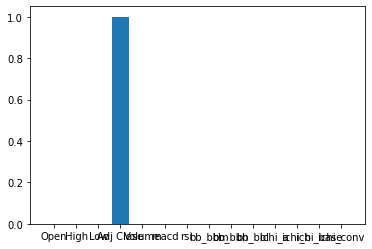

In [6]:
Lstock = stock.drop(['Close','Date'],1)
model = LinearRegression()
model.fit(Lstock.iloc[:,:], stock.iloc[:,4])
importance = model.coef_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([Lstock.columns[x] for x in range(len(importance))], importance)
plt.show()
stock_final = stock.drop(['Date','Open','Volume','macd','bb_bbm','bb_bbh','bb_bbl','ichi_a','ichi_conv'],1)

## 4. Model Construction

### 4.1 Data Processing


In [7]:
window_size = 50
week = 7
X = []
Y = []
print(stock_final)
for i in range(0 , len(stock) - window_size -1 , 1):
    X.append(np.array(stock_final.iloc[i:i+window_size,:]).reshape(window_size * 7,1))
    Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
train_X,test_X,train_label,test_label = train_test_split(X, Y, test_size=0.1,shuffle=False)
len_t = len(train_X)

train_X = np.array(train_X)
test_X = np.array(test_X)
train_label = np.array(train_label)
test_label = np.array(test_label)
train_X = train_X.reshape(train_X.shape[0],7,50,1)
test_X = test_X.reshape(test_X.shape[0],7,50,1)

         High       Low     Close  Adj Close       rsi    ichi_b  ichi_base
0    0.844709  0.832156  0.852707   0.852707  0.000000  0.874333   0.000000
1    0.831085  0.792517  0.797240   0.797240  0.000000  0.849830   0.000000
2    0.840212  0.823783  0.832803   0.832803  0.000000  0.849830   0.000000
3    0.839815  0.832679  0.840101   0.840101  0.000000  0.849830   0.000000
4    0.849074  0.838435  0.828822   0.828822  0.000000  0.852499   0.000000
..        ...       ...       ...        ...       ...       ...        ...
751  0.331349  0.347200  0.331077   0.331077  0.673273  0.289665   0.478169
752  0.322090  0.330717  0.327229   0.327229  0.659901  0.289665   0.474652
753  0.335582  0.343407  0.336385   0.336385  0.689183  0.289665   0.467781
754  0.327249  0.347070  0.325239   0.325239  0.648039  0.289665   0.467781
755  0.327646  0.343668  0.321258   0.321258  0.633493  0.289665   0.467781

[756 rows x 7 columns]


### 4.2 Predicting

In [8]:
model = Sequential()
#add model layers
model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu', input_shape=(None,50,1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(256, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(512, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.fit(train_X, train_label, validation_data=(test_X,test_label), epochs=100)
print(model.summary())
print(model.evaluate(test_X,test_label))

predicted  = model.predict(test_X)
test_label[:,0] = y_scaler.inverse_transform(test_label[:,0])
predicted = np.array(predicted[:,0]).reshape(-1,1)
predicted = y_scaler.inverse_transform(predicted)

Epoch 1/100
20/20 [==============================] - 23s 535ms/step - loss: 0.0920 - val_loss: 0.0035
Epoch 2/100
20/20 [==============================] - 6s 296ms/step - loss: 0.0262 - val_loss: 0.0037
Epoch 3/100
20/20 [==============================] - 8s 376ms/step - loss: 0.0175 - val_loss: 0.0043
Epoch 4/100
20/20 [==============================] - 7s 338ms/step - loss: 0.0168 - val_loss: 0.0037
Epoch 5/100
20/20 [==============================] - 9s 451ms/step - loss: 0.0139 - val_loss: 0.0025
Epoch 6/100
20/20 [==============================] - 5s 225ms/step - loss: 0.0106 - val_loss: 0.0025
Epoch 7/100
20/20 [==============================] - 5s 228ms/step - loss: 0.0089 - val_loss: 0.0025
Epoch 8/100
20/20 [==============================] - 8s 402ms/step - loss: 0.0101 - val_loss: 0.0022
Epoch 9/100
15/20 [=====================>........] - ETA: 2s - loss: 0.0086

KeyboardInterrupt: 

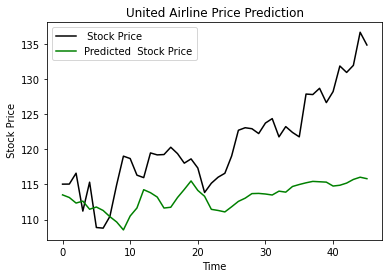

In [ ]:
plt.plot(test_label[:,0], color = 'black', label = ' Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.title('United Airline Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()